In [1]:
from __future__ import annotations

import pandas as pd
import numpy as np

from typing import Literal, Final, List, TypeVar, Dict, Tuple, Any, Optional, Iterable, Union, NoReturn
import sklearn
import dataclasses
import os


from sklearn.linear_model import ARDRegression, SGDClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import set_config

set_config(display="diagram")

from assignment2.a2_utils.seed_utils import *

from assignment2.a2_utils.misc_utils import *

import assignment2.a2_utils.seed_utils as seed_utils
import assignment2.a2_utils.misc_utils as misc_utils
import assignment2.a2_utils.metric_utils as metric_utils
import assignment2.a2_utils.dataframe_utils as df_utils
import assignment2.a2_utils.simple_learner_utils as slearner

import econml


import pickle

import dill

In [2]:
dataset: Literal["ihdp","jobs"] = "jobs"

In [3]:
import warnings
warnings.filterwarnings("ignore")

#print(sns.plotting_context())



import matplotlib.style
if "seaborn-darkgrid" in matplotlib.style.available:
    matplotlib.style.use("seaborn-darkgrid")

%matplotlib inline

In [4]:



""

''

# JOBS dataset processing


In [5]:

jobs_full: pd.DataFrame = df_utils.turn_01_columns_into_int(
    pd.read_csv(f"{dataset}_full.csv")
)
"The full JOBS dataset as a dataframe"

jobs_full.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x11,x12,x13,x14,x15,x16,t,y,e,tcf
0,-0.614282,1.464727,0,0,1,0,2.393250,2.746196,-0.653311,-0.656913,...,2.462337,2.937244,0,0,2.843909,0,0,1,0,1
1,-0.802463,0.101835,0,0,1,0,0.109885,0.498271,-0.785284,-0.743407,...,-0.177193,0.082537,0,0,0.038422,0,0,1,0,1
2,-0.896553,-0.238888,1,0,1,1,-0.085212,-0.148097,-0.847312,-0.781606,...,-0.286221,-0.303615,0,0,-0.191304,0,0,1,0,1
3,-0.896553,-0.238888,0,0,0,1,0.405581,0.325594,-0.847312,-0.781606,...,0.023020,-0.039630,0,0,0.173108,0,0,1,1,1
4,0.138440,-1.601779,1,0,1,1,-0.722531,-0.212734,-0.019840,-0.156019,...,-0.514563,-0.331552,0,0,-0.779227,0,0,1,0,1


In [6]:
jobs_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3212 entries, 0 to 3211
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x0      3212 non-null   float64
 1   x1      3212 non-null   float64
 2   x2      3212 non-null   uint8  
 3   x3      3212 non-null   uint8  
 4   x4      3212 non-null   uint8  
 5   x5      3212 non-null   uint8  
 6   x6      3212 non-null   float64
 7   x7      3212 non-null   float64
 8   x8      3212 non-null   float64
 9   x9      3212 non-null   float64
 10  x10     3212 non-null   float64
 11  x11     3212 non-null   float64
 12  x12     3212 non-null   float64
 13  x13     3212 non-null   uint8  
 14  x14     3212 non-null   uint8  
 15  x15     3212 non-null   float64
 16  x16     3212 non-null   uint8  
 17  t       3212 non-null   uint8  
 18  y       3212 non-null   uint8  
 19  e       3212 non-null   uint8  
 20  tcf     3212 non-null   uint8  
dtypes: float64(10), uint8(11)
memory usag

In [7]:
dfm: df_utils.DataframeManager = df_utils.DataframeManager.make(
    dataset_name = dataset,
    the_df = jobs_full,
    test_proportion = 0.2,
    split_randomstate = rng_state(),
    columns_for_training_stratification= ["t","e","y"],
    t_column = "t",
    t_cf_column = "tcf",
    y_column = "y",
    e_column = "e",

)


In [8]:
dfm.save_self()

pickling self as \jobs\jobs DataframeManager.pickle...
pickled!


True

# Part 3 - Simple Learners

In [115]:
%%time

rf_min_samples = [2,4,6]
rf_min_impurity_decrease =  [0, *np.geomspace(0.00001, 0.15,5)[1:]]
rf_max_features = [None,"sqrt","log2",0.5,2]
rf_ccp_alpha =  [0, *np.geomspace(0.00001, 0.15,5)[1:]]
rf_n_estimators = [50,100,150]

rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features":rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)


-- 10-fold attempt 1/3 start --
max: 50, min: 7, factor: 8
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 375
n_resources: 7
Fitting 10 folds for each of 375 candidates, totalling 3750 fits
----------
iter: 1
n_candidates: 47
n_resources: 7
Fitting 10 folds for each of 47 candidates, totalling 470 fits
----------
iter: 2
n_candidates: 6
n_resources: 7
Fitting 10 folds for each of 6 candidates, totalling 60 fits
best from this iteration: 
GridSearchResults summary Random Forest simple jobs
	test score:	0.8179323774119313
	train score:0.826600790834749
	y score:	0.6673126320429225
	abs ATT:	0.008564072093483865
	p. risk:	0.0023670286828181286

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 100, min: 1, factor: 10
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resources_: 100
aggressive_elimination: True
factor: 10
-

In [116]:

rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_searched
)


In [117]:

print(rf_simple_best.info)



rf_simple_best.best_estimator_


GridSearchResults summary Random Forest simple jobs
	test score:	0.8294742432288901
	train score:0.8285306670634718
	y score:	0.6609069353882633
	abs ATT:	0.8637353931471579
	p. risk:	0.03773745194831202
	best params:
		estimator__ccp_alpha : 0.0012247448713915891
		estimator__max_features : sqrt
		estimator__min_impurity_decrease : 0
		estimator__min_samples_split : 4
		estimator__n_estimators : 12


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestClassifier(ccp_alpha=0.0012247448713915891,
                                         max_features='sqrt',
                                         min_impurity_decrease=0,
                                         min_samples_split=4, n_estimators=12,
                                         random_state=42))])

In [118]:
rf_simple_best.save_me()

Pickling results to: \jobs\jobs Random Forest simple results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Random Forest simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Random Forest simple feature importances.pdf


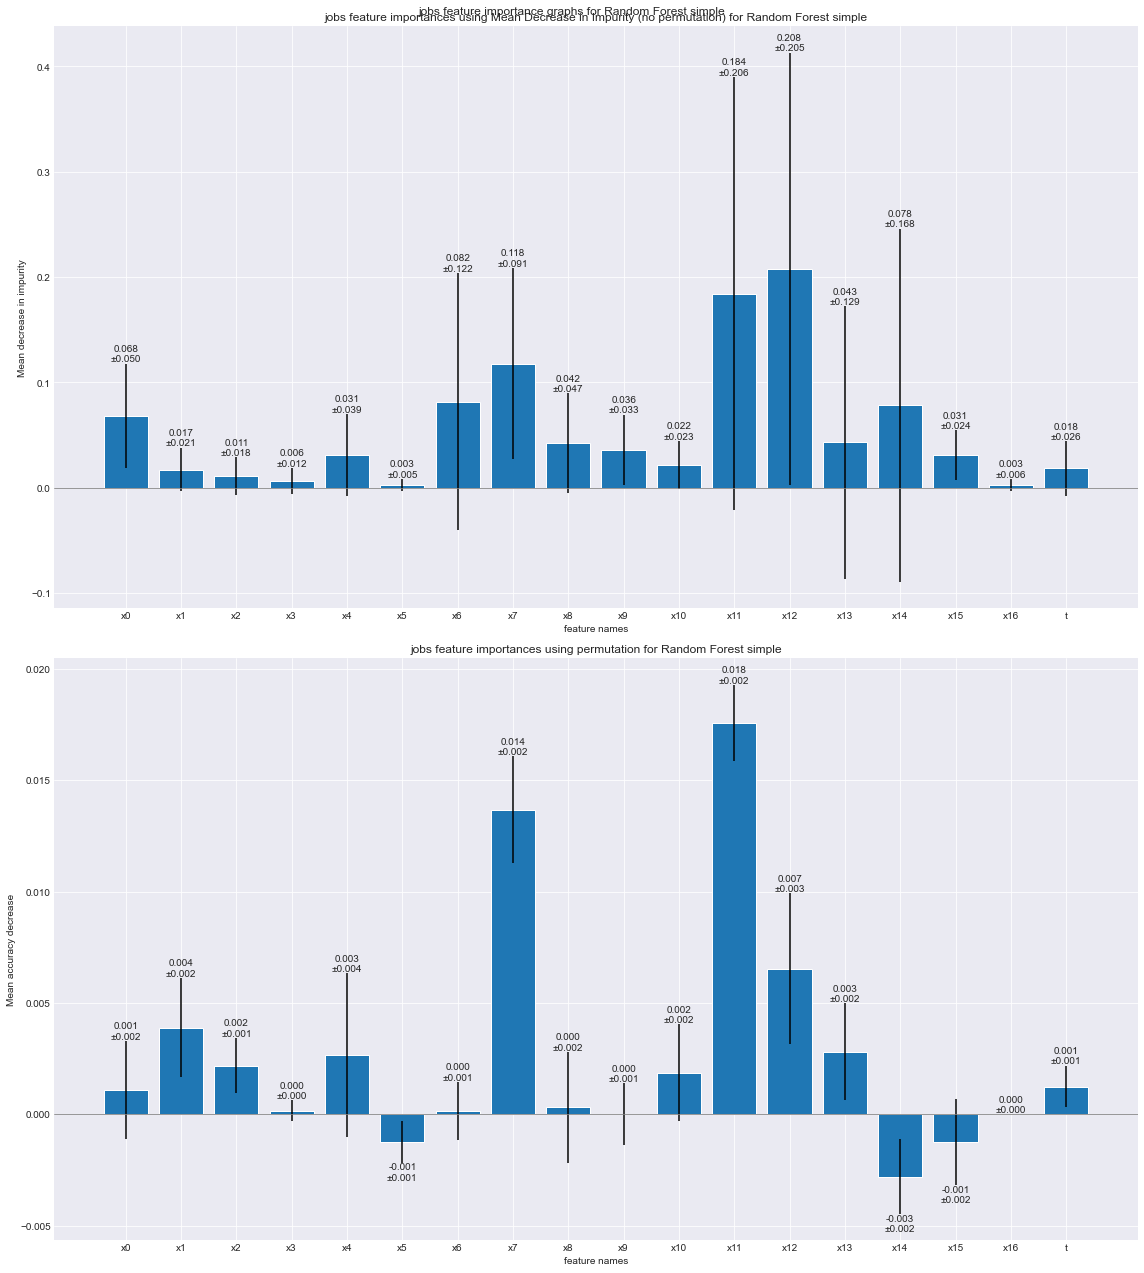

In [119]:
rf_simple_best.importance_plotter().show()

Permutation explainer: 644it [43:22,  4.05s/it]                          


Saving SHAP figure to jobs\jobs SHAP values for Random Forest simple.pdf...


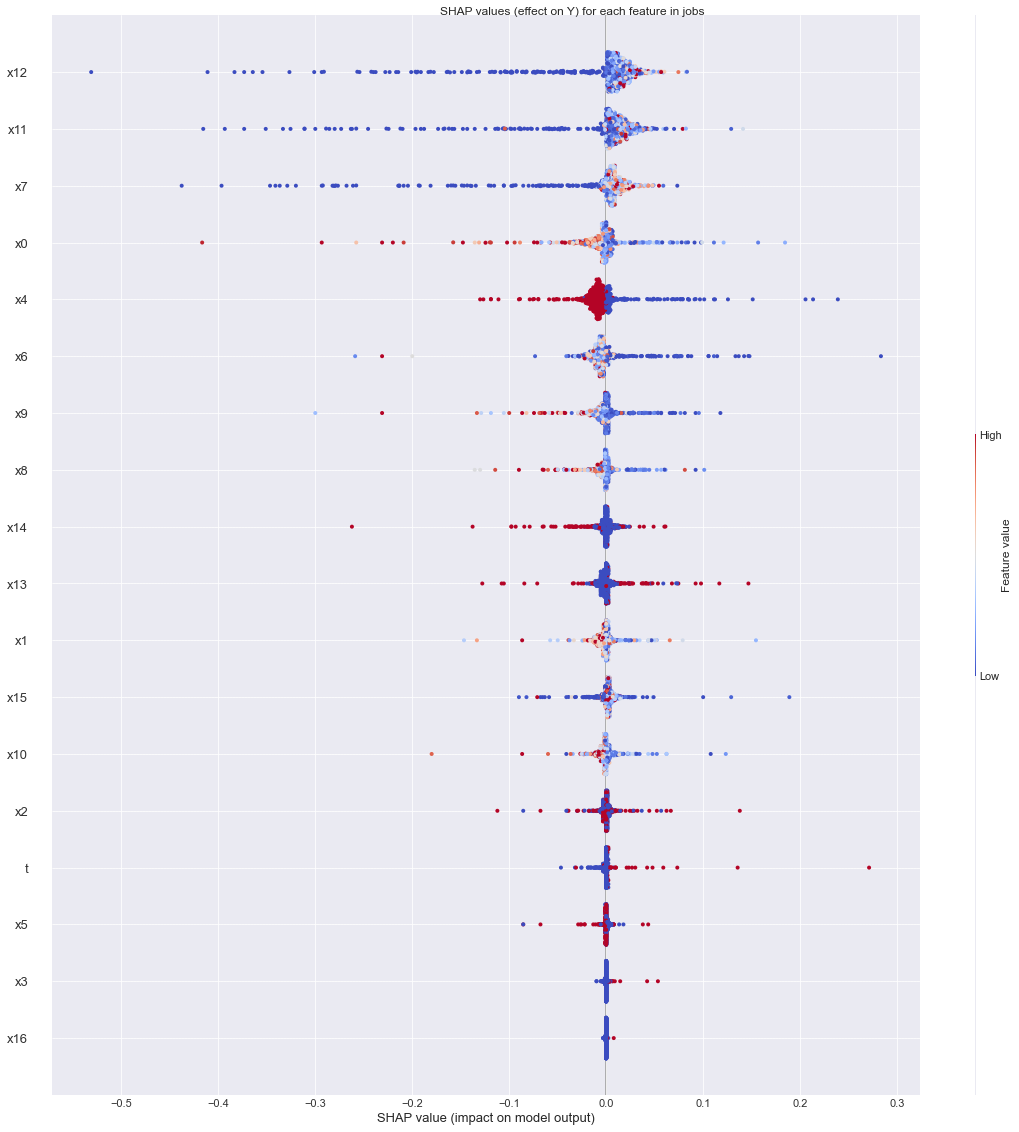

In [156]:
rf_simple_best.shap_importance_plotter().show()

In [157]:
%%time

ard_iter: List[int] = [200, 250, 300]
ard_tol: List[float] = [1e-2, 1e-3, 1e-4]
ard_alpha_lambda: List[float] = [1e-5, 1e-6, 1e-7]
ard_thresh_lambda: List[float] = [1e3, 1e4, 1e5]



ard_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1" : ard_alpha_lambda,
        "estimator__alpha_2" : ard_alpha_lambda,
        "estimator__lambda_1" : ard_alpha_lambda,
        "estimator__lambda_2" : ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t","y"],
    resource="estimator__n_iter",
    resource_param_values=ard_iter
)

-- 10-fold attempt 1/3 start --
max: 200, min: 14, factor: 15
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 14
max_resources_: 200
aggressive_elimination: True
factor: 15
----------
iter: 0
n_candidates: 729
n_resources: 14
Fitting 10 folds for each of 729 candidates, totalling 7290 fits
----------
iter: 1
n_candidates: 49
n_resources: 14
Fitting 10 folds for each of 49 candidates, totalling 490 fits
----------
iter: 2
n_candidates: 4
n_resources: 14
Fitting 10 folds for each of 4 candidates, totalling 40 fits
best from this iteration: 
GridSearchResults summary ARD simple jobs
	test score:	0.812303062488936
	train score:0.8231367303267086
	y score:	0.822169151733467
	abs ATT:	0.007332531390236374
	p. risk:	0.2715483329173295

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 250, min: 16, factor: 16
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 1
min_resources_: 16
max_resources_: 250
aggressive_elimination: True
factor: 16
----

In [158]:

ard_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_searched
)




In [159]:

print(ard_simple_best.info)


ard_simple_best.best_estimator_


GridSearchResults summary ARD simple jobs
	test score:	0.812303062488936
	train score:0.8231367303267086
	y score:	0.822169151733467
	abs ATT:	0.007332531390236374
	p. risk:	0.2715483329173295
	best params:
		estimator__alpha_1 : 1e-05
		estimator__alpha_2 : 1e-07
		estimator__lambda_1 : 1e-05
		estimator__lambda_2 : 1e-06
		estimator__threshold_lambda : 10000.0
		estimator__tol : 0.001
		estimator__n_iter : 14


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  ARDRegression(alpha_1=1e-05, alpha_2=1e-07, lambda_1=1e-05,
                                n_iter=14))])

In [160]:
ard_simple_best.save_me()

Pickling results to: \jobs\jobs ARD simple results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs ARD simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs ARD simple feature importances.pdf


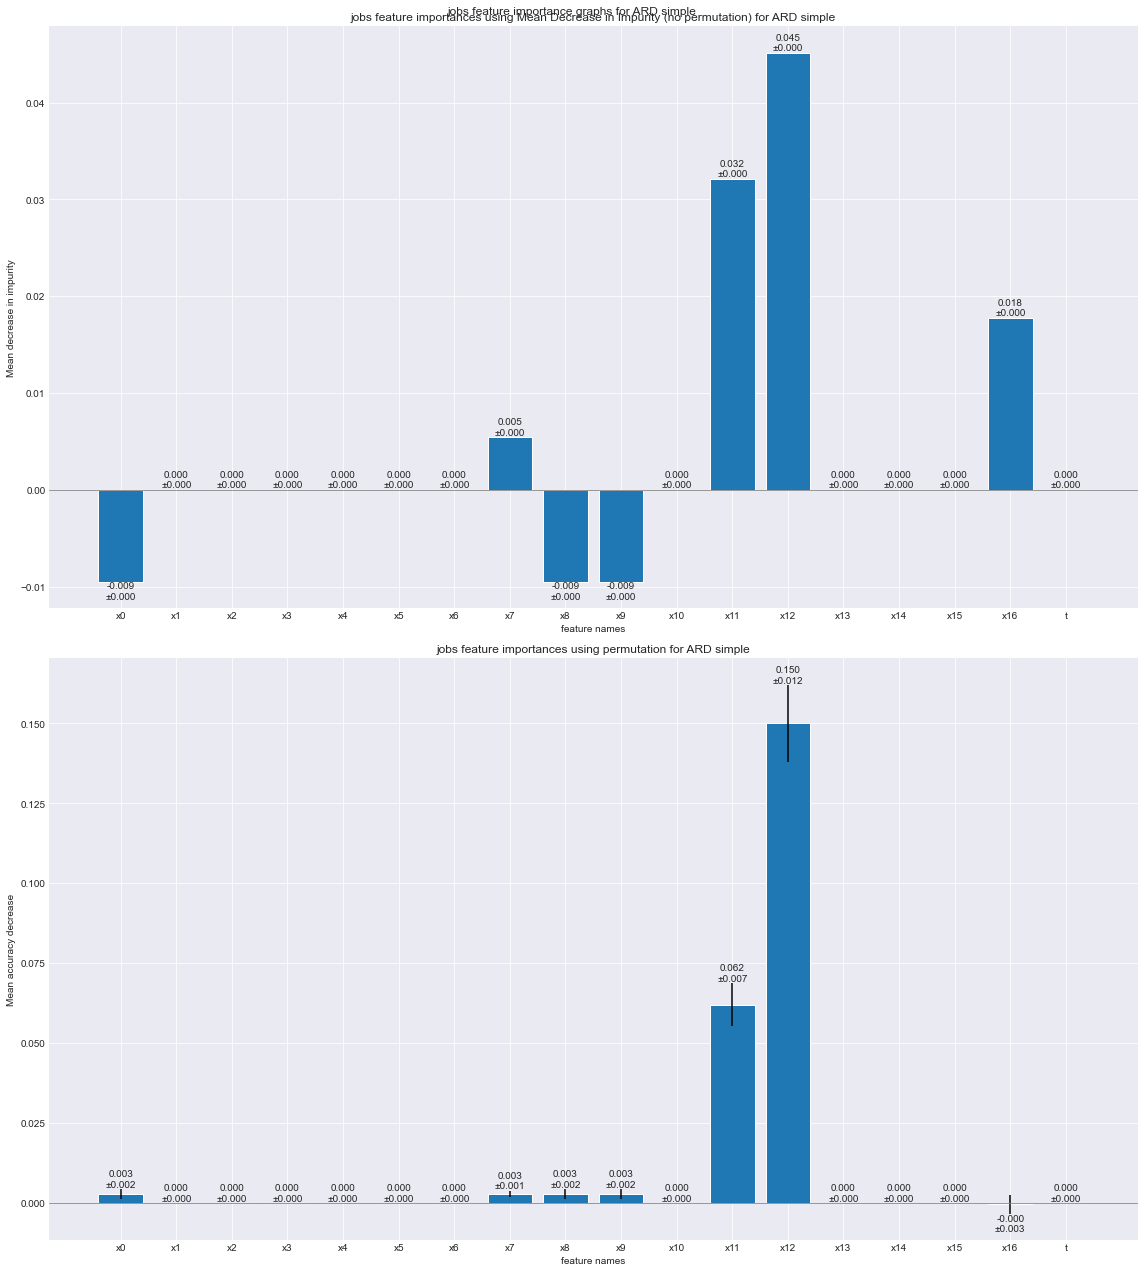

In [161]:
ard_simple_best.importance_plotter().show()

In [162]:
ard_simple_best.shap_importance_plotter().show()

Permutation explainer:  27%|██▋       | 173/643 [08:22<23:16,  2.97s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\PycharmProjects\ce888\venv38\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Rachel\AppData\Local\Temp\ipykernel_812\1114471025.py", line 1, in <cell line: 1>
    ard_simple_best.shap_importance_plotter().show()
  File "D:\PycharmProjects\ce888\project\assignment2\a2_utils\simple_learner_utils.py", line 519, in shap_importance_plotter
  File "C:\Users\Rachel\AppData\Local\Programs\Python\Python38\lib\functools.py", line 967, in __get__
    val = self.func(instance)
  File "D:\PycharmProjects\ce888\project\assignment2\a2_utils\simple_learner_utils.py", line 514, in _shap_values
    return self._shap_explainer(self.predictions.iloc[:, self.predictions.columns.isin(self.x_t_column_names)].loc[self.test_indices])
  File "D:\PycharmProjects\ce888\venv38\lib\site-packages\shap\explainers\_explainer.py", line 255, in __call__
    row_result = self.ex

In [121]:
%%time

sgd_max_iter: List[int] = [500,1000,1500]
sgd_alpha: List[float] = [0.001, 0.0001, 0.00001]
sgd_learning_rate: List[str] =  ["constant","optimal","invscaling","adaptive"]
sgd_power_t: List[float] = [0.25,0.5,0.75]
sgd_l1_ratio: List[float] = [0, 0.5, 1]

sgd_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t","y"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)

-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 108
n_resources: 22
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
----------
iter: 1
n_candidates: 5
n_resources: 22
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best from this iteration: 
GridSearchResults summary sgd simple jobs
	test score:	0.7625774473358117
	train score:0.7500681639560515
	y score:	0.6219111455625979
	abs ATT:	0.014688057040998292
	p. risk:	0.07529411764705884

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 32
max_resources_: 1000
aggressive_elimination: True
factor: 32
----------
iter: 0
n_candidates: 108
n_resources: 32
Fitting 10 folds for each of 108 candidates, totalling 1080 f

In [122]:

sgd_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_searched
)



In [123]:

print(sgd_simple_best.info)

sgd_simple_best.best_estimator_


GridSearchResults summary sgd simple jobs
	test score:	0.7625774473358117
	train score:0.7500681639560515
	y score:	0.6219111455625979
	abs ATT:	0.014688057040998292
	p. risk:	0.07529411764705884
	best params:
		estimator__alpha : 0.001
		estimator__l1_ratio : 1
		estimator__learning_rate : optimal
		estimator__power_t : 0.75
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDClassifier(alpha=0.001, early_stopping=True, l1_ratio=1,
                                max_iter=22, penalty='elasticnet', power_t=0.75,
                                random_state=42))])

In [124]:
sgd_simple_best.save_me()

Pickling results to: \jobs\jobs sgd simple results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs sgd simple estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs sgd simple feature importances.pdf


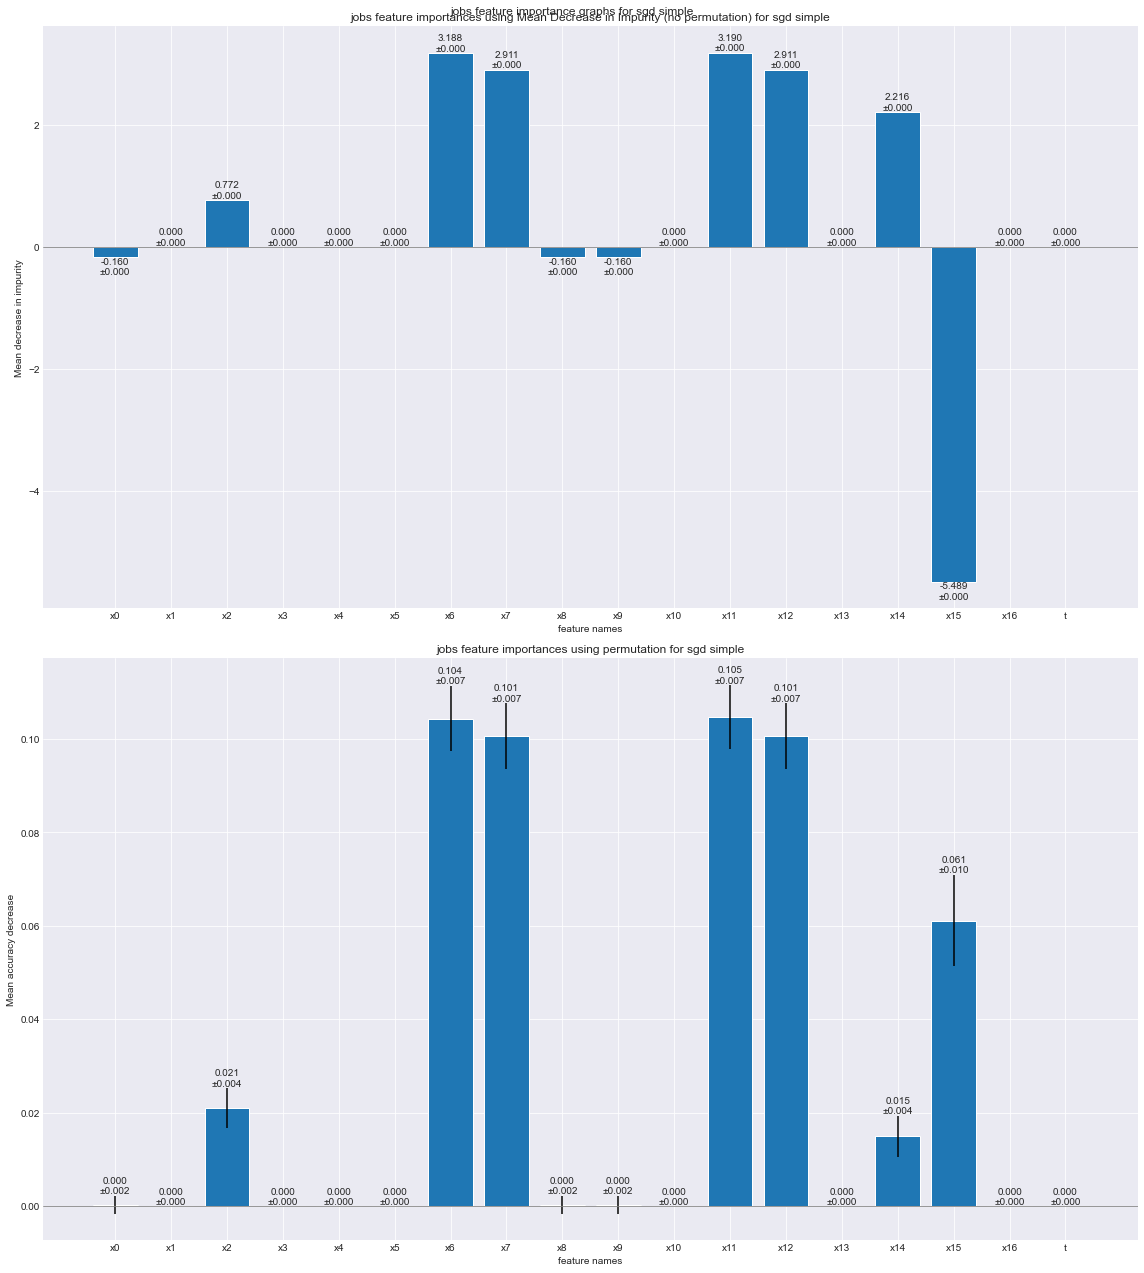

In [125]:
sgd_simple_best.importance_plotter().show()

Permutation explainer: 644it [20:57,  1.97s/it]                         


Saving SHAP figure to jobs\jobs SHAP values for sgd simple.pdf...


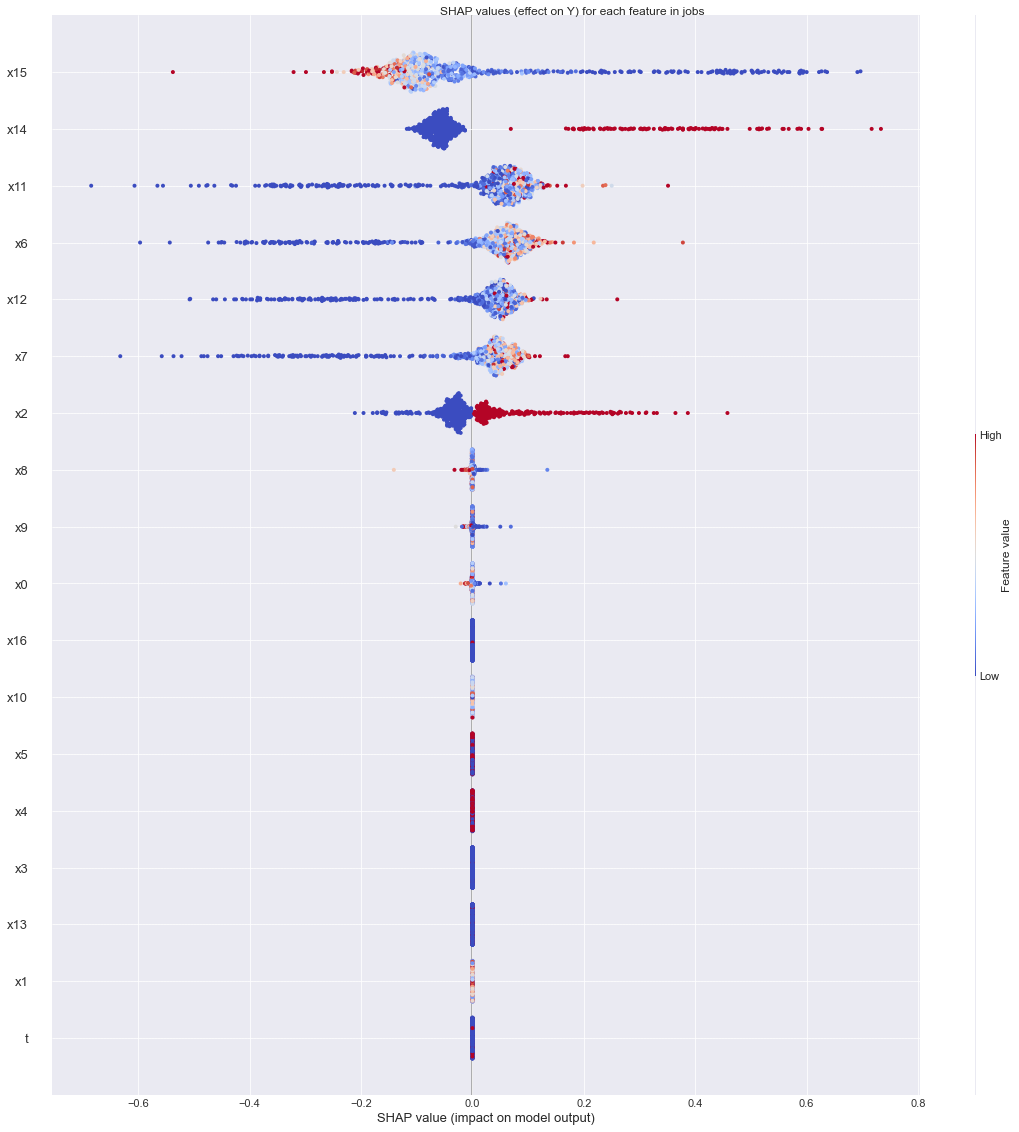

In [126]:
sgd_simple_best.shap_importance_plotter().show()

In [ ]:
%%time

adaboost_estimators: List[int] = [25, 50, 75]
adaboost_learn_rate: List[float] = [0.8, 1.0, 1.2]

ada_rf_simple_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state = seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:

ada_rf_simple_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_searched
)



In [ ]:

print(ada_rf_simple_best.info)



ada_rf_simple_best.best_estimator_


In [ ]:
ada_rf_simple_best.save_me()

In [ ]:
ada_rf_simple_best.importance_plotter().show()

In [ ]:
ada_rf_simple_best.shap_importance_plotter().show()

In [ ]:
del rf_simple_searched
del ard_simple_searched
del sgd_simple_searched
del ada_rf_simple_searched

In [ ]:


all_simple_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_best,
    ard_simple_best,
    sgd_simple_best,
    ada_rf_simple_best
]

all_simple_best.sort(reverse=True)


In [ ]:
for bc in all_simple_best:
    print(bc.summary_info)

print("")

In [ ]:
print(max(all_simple_best).info)

In [ ]:
best_simple_est: slearner.PPipeline = max(all_simple_best).best_estimator_

# Part 4 - Inverse Propensity Weights


### attempting to find the likelihood of individuals being NOT being included in the treatment group

In [37]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier

In [40]:
%%time

rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split":rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha": rf_ccp_alpha,
        "estimator__class_weight": ["balanced", "balanced subsample"],
    },
    df_m=dfm.e1_dataframe,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=rf_n_estimators,
)

-- 10-fold attempt 1/3 start --
max: 50, min: 7, factor: 8
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 750
n_resources: 7
Fitting 10 folds for each of 750 candidates, totalling 7500 fits
----------
iter: 1
n_candidates: 94
n_resources: 7
Fitting 10 folds for each of 94 candidates, totalling 940 fits
----------
iter: 2
n_candidates: 12
n_resources: 7
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 3
n_candidates: 2
n_resources: 7
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best from this iteration: 
GridSearchResults summary Random Forest IPSW jobs
	test score:	0.47647527910685805
	train score:0.514401366607249
	y score:	0.7754208754208755

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 100, min: 1, factor: 10
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1
max_resourc

In [41]:

rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_ipsw_searched
)



In [42]:
print(rf_ipsw_best.info)

rf_ipsw_best.best_estimator_

GridSearchResults summary Random Forest IPSW jobs
	test score:	0.5804425837320574
	train score:0.5061757278669045
	y score:	0.5048682907506438
	best params:
		estimator__ccp_alpha : 0.00011066819197003216
		estimator__class_weight : balanced
		estimator__max_features : 2
		estimator__min_impurity_decrease : 0.013554030054147676
		estimator__min_samples_split : 4
		estimator__n_estimators : 100


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  RandomForestClassifier(ccp_alpha=0.00011066819197003216,
                                         class_weight='balanced',
                                         max_features=2,
                                         min_impurity_decrease=0.013554030054147676,
                                         min_samples_split=4,
                                         random_state=42))])

In [43]:
rf_ipsw_best.save_me()

Pickling results to: \jobs\jobs Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Random Forest IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Random Forest IPSW feature importances.pdf


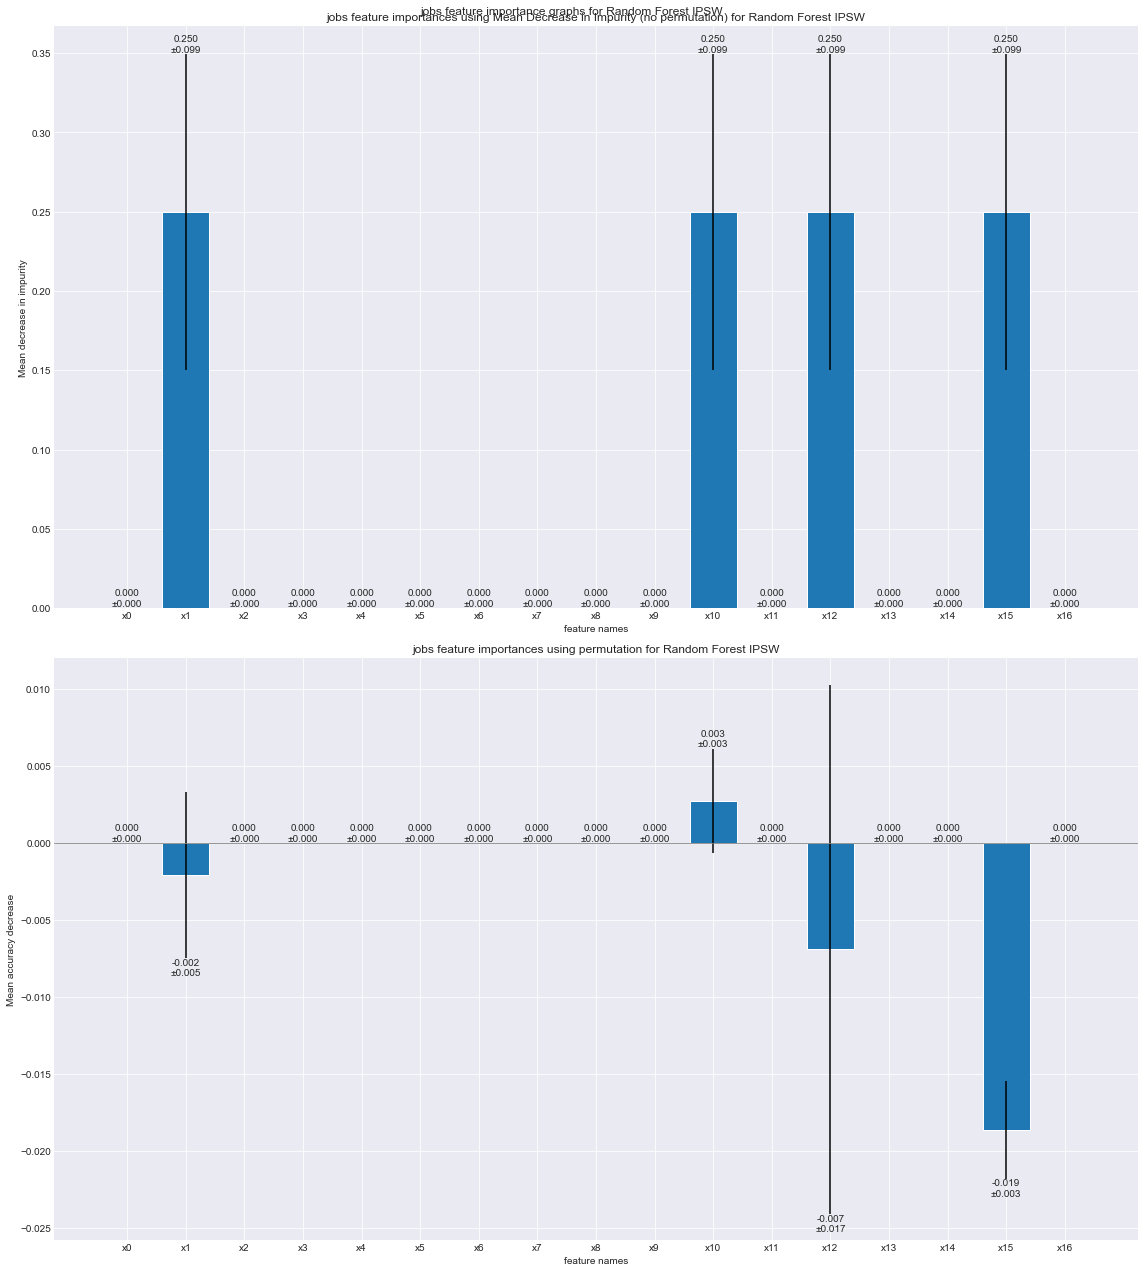

In [44]:
rf_ipsw_best.importance_plotter().show()

Permutation explainer: 146it [00:49,  2.42it/s]                         


Saving SHAP figure to jobs\jobs SHAP values for Random Forest IPSW.pdf...


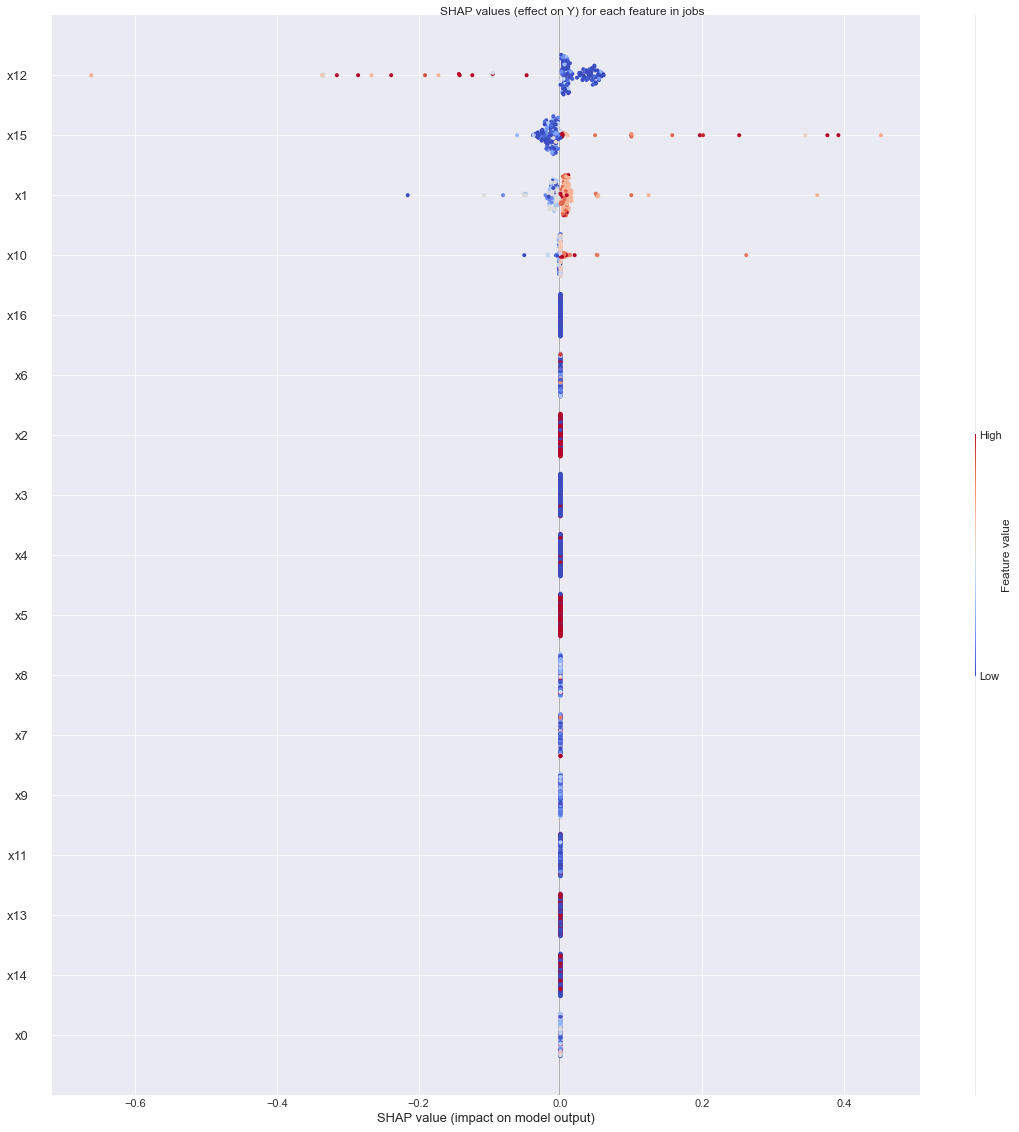

In [45]:
rf_ipsw_best.shap_importance_plotter().show()

In [46]:
%%time

# note: ridge does not support predict_proba, unusable, replaced with SGDClassifier.

sgd_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        n_jobs=-1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        loss="log",
        penalty="elasticnet"
    ),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio,
        "estimator__class_weight": ["balanced", None]
    },
    df_m=dfm.e1_dataframe,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="sgd IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter
)


-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 216
n_resources: 22
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
----------
iter: 1
n_candidates: 10
n_resources: 22
Fitting 10 folds for each of 10 candidates, totalling 100 fits
best from this iteration: 
GridSearchResults summary sgd IPSW jobs
	test score:	0.6203149920255183
	train score:0.5289494206773618
	y score:	0.5435412953060011

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 32
max_resources_: 1000
aggressive_elimination: True
factor: 32
----------
iter: 0
n_candidates: 216
n_resources: 32
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
----------
iter: 1
n_candidates: 7
n_resources: 32
Fitti

In [47]:
sgd_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_ipsw_searched
)

In [48]:

print(sgd_ipsw_best.info)

sgd_ipsw_best.best_estimator_

GridSearchResults summary sgd IPSW jobs
	test score:	0.6203149920255183
	train score:0.5289494206773618
	y score:	0.5435412953060011
	best params:
		estimator__alpha : 1e-05
		estimator__class_weight : None
		estimator__l1_ratio : 0
		estimator__learning_rate : optimal
		estimator__power_t : 0.25
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDClassifier(alpha=1e-05, early_stopping=True, l1_ratio=0,
                                loss='log', max_iter=22, n_jobs=-1,
                                penalty='elasticnet', power_t=0.25,
                                random_state=42))])

In [49]:

sgd_ipsw_best.save_me()

Pickling results to: \jobs\jobs sgd IPSW results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs sgd IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs sgd IPSW feature importances.pdf


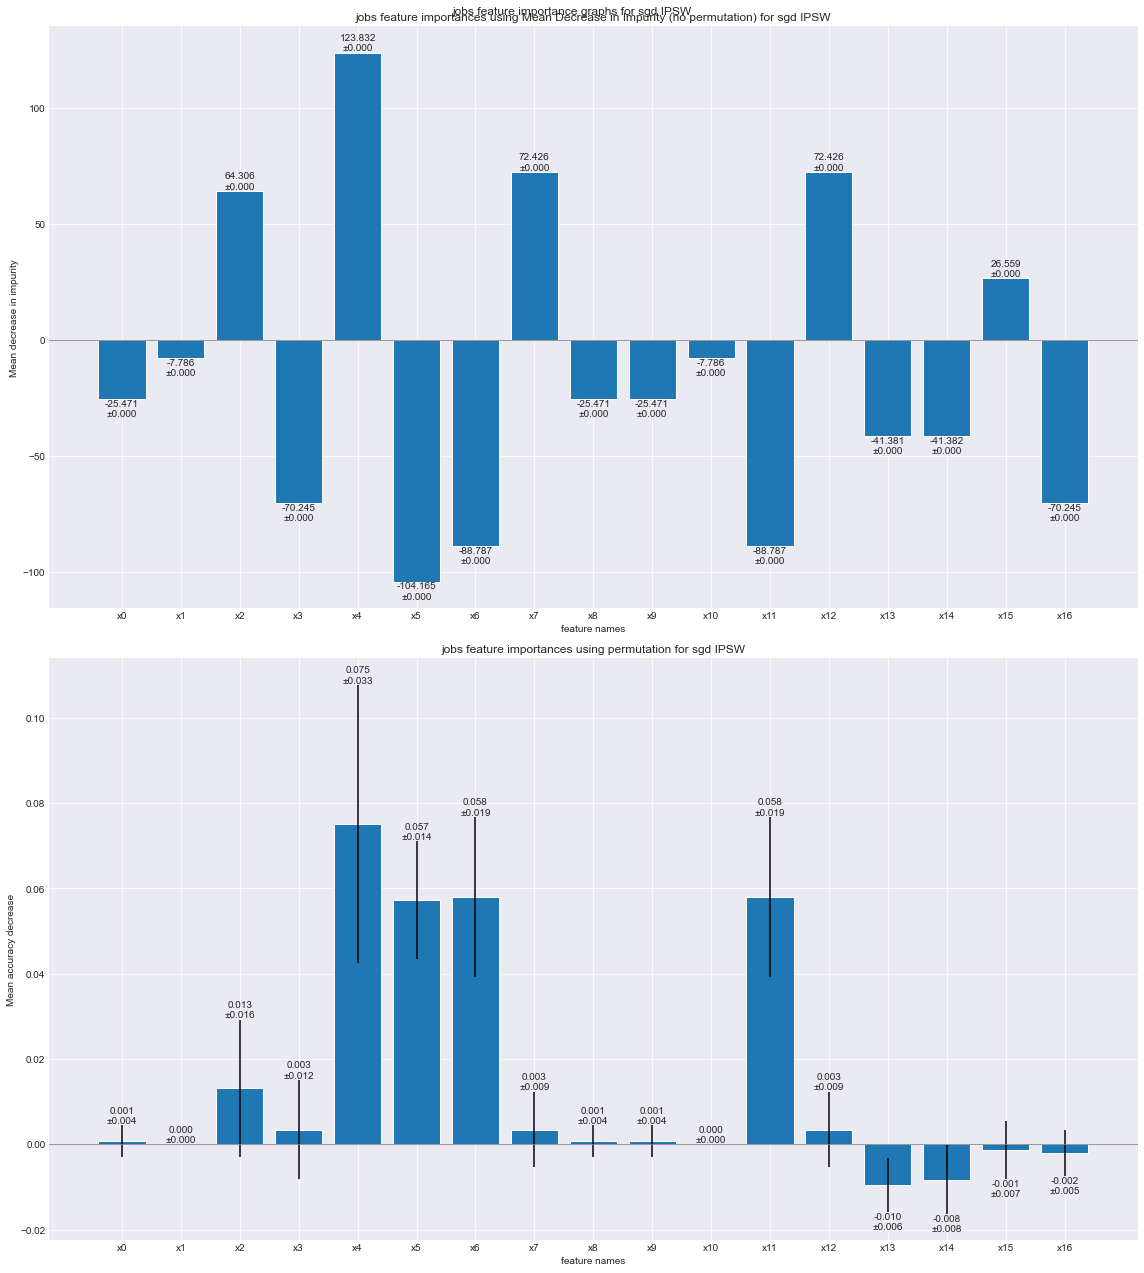

In [50]:

sgd_ipsw_best.importance_plotter().show()

Permutation explainer: 146it [00:21,  3.62it/s]                         


Saving SHAP figure to jobs\jobs SHAP values for sgd IPSW.pdf...


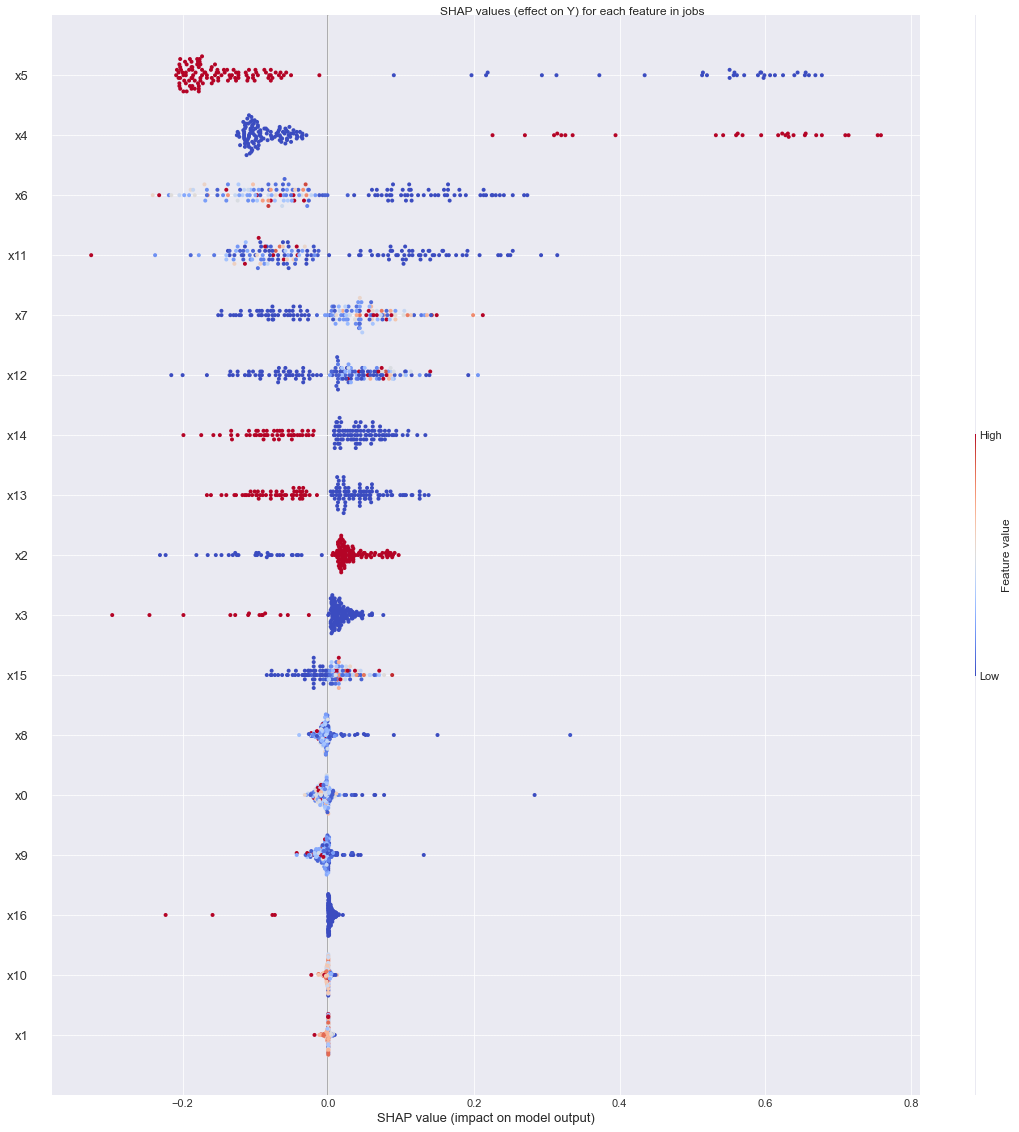

In [51]:
sgd_ipsw_best.shap_importance_plotter().show()

In [52]:
%%time

ada_rf_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state = seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_ipsw_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm.e1_dataframe,
    df_selection=df_utils.DatasetEnum.X_T,
    learner_name="Adaboost Random Forest IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t"],
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

-- 10-fold attempt 1/3 start --
max: 25, min: 1, factor: 5
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 3
min_resources_: 1
max_resources_: 25
aggressive_elimination: True
factor: 5
----------
iter: 0
n_candidates: 21
n_resources: 5
Fitting 10 folds for each of 21 candidates, totalling 210 fits
----------
iter: 1
n_candidates: 5
n_resources: 25
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best from this iteration: 
GridSearchResults summary Adaboost Random Forest IPSW jobs
	test score:	0.4944178628389155
	train score:0.5140987076648841
	y score:	0.8489086947910478

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 50, min: 7, factor: 8
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 7
max_resources_: 50
aggressive_elimination: True
factor: 8
----------
iter: 0
n_candidates: 21
n_resources: 7
Fitting 10 folds for each of 21 candidates, totalling 210 fits
----------
iter: 1
n_candidates: 3
n_resources: 7
Fitting 10 f

In [53]:
ada_rf_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_ipsw_searched
)

In [54]:

print(ada_rf_ipsw_best.info)

ada_rf_ipsw_best.best_estimator_

GridSearchResults summary Adaboost Random Forest IPSW jobs
	test score:	0.4973086124401913
	train score:0.5099209001782531
	y score:	0.8436957813428402
	best params:
		estimator__base_estimator : DecisionTreeClassifier(max_depth=10, random_state=42)
		estimator__learning_rate : 0.8
		estimator__n_estimators : 7


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                                           random_state=42),
                                     learning_rate=0.8, n_estimators=7,
                                     random_state=42))])

In [55]:

ada_rf_ipsw_best.save_me()

Pickling results to: \jobs\jobs Adaboost Random Forest IPSW results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs Adaboost Random Forest IPSW estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs Adaboost Random Forest IPSW feature importances.pdf


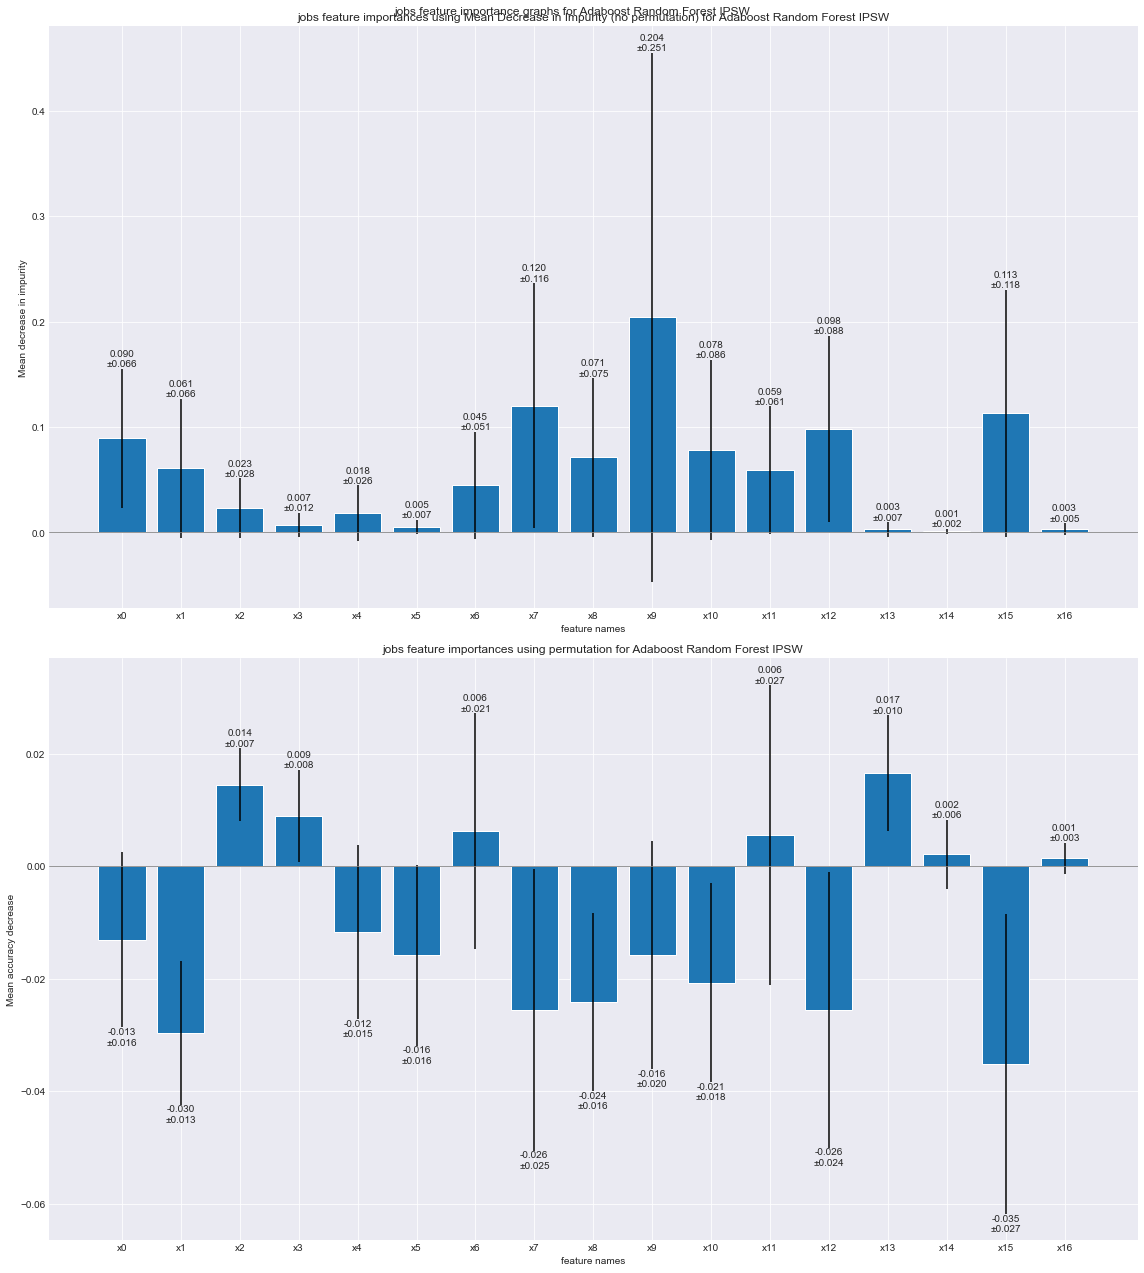

In [56]:

ada_rf_ipsw_best.importance_plotter().show()

Permutation explainer: 146it [07:57,  3.34s/it]                         


Saving SHAP figure to jobs\jobs SHAP values for Adaboost Random Forest IPSW.pdf...


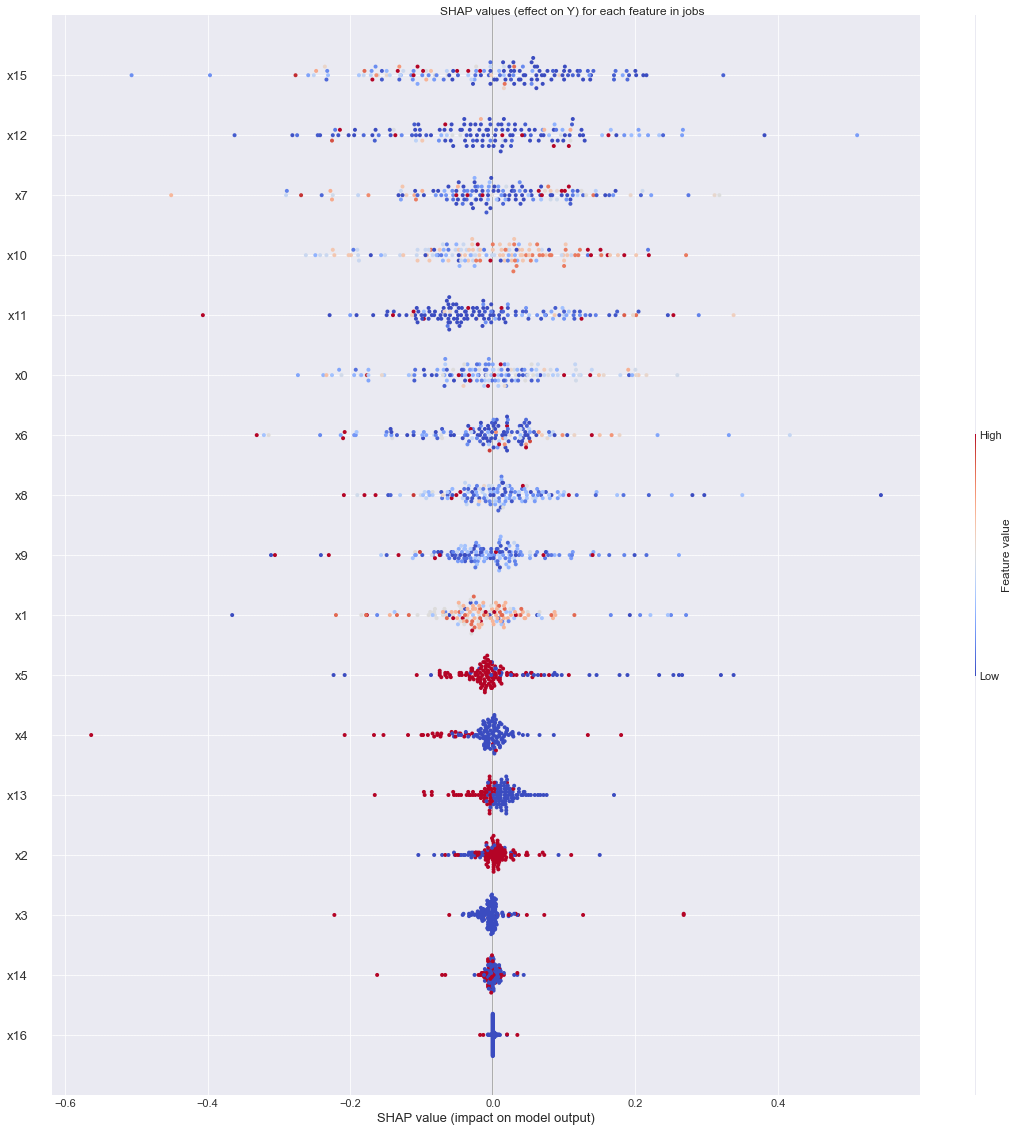

In [111]:
ada_rf_ipsw_best.shap_importance_plotter().show()

In [57]:
del rf_ipsw_searched
del sgd_ipsw_searched
del ada_rf_ipsw_searched

In [58]:
all_ipsw_clf_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_ipsw_best,
    sgd_ipsw_best,
    ada_rf_ipsw_best
]

all_ipsw_clf_best.sort(reverse=True)

for bc in all_ipsw_clf_best:
    print(bc.summary_info)

print("")

GridSearchResults summary sgd IPSW jobs
	test score:	0.6203149920255183
	train score:0.5289494206773618
	y score:	0.5435412953060011
GridSearchResults summary Random Forest IPSW jobs
	test score:	0.5804425837320574
	train score:0.5061757278669045
	y score:	0.5048682907506438
GridSearchResults summary Adaboost Random Forest IPSW jobs
	test score:	0.4973086124401913
	train score:0.5099209001782531
	y score:	0.8436957813428402



In [112]:
print(max(all_ipsw_clf_best).info)

GridSearchResults summary sgd IPSW jobs
	test score:	0.6203149920255183
	train score:0.5289494206773618
	y score:	0.5435412953060011
	best params:
		estimator__alpha : 1e-05
		estimator__class_weight : None
		estimator__l1_ratio : 0
		estimator__learning_rate : optimal
		estimator__power_t : 0.25
		estimator__max_iter : 22


In [59]:
best_ipsw_predictor: slearner.PPipeline = max(all_ipsw_clf_best).best_estimator_

ipsw_calc: slearner.IpswWrapper = slearner.IpswWrapper.make(
    best_ipsw_predictor,
    dataset_name=dataset
)

ipsw_calc.save_me()


### And now using these weights to redo the earlier simple estimators

In [ ]:
%%time


rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    RandomForestClassifier(random_state=seed()),
    {
        #"estimator__n_estimators": [75,100,125],
        "estimator__min_samples_split": rf_min_samples,
        "estimator__min_impurity_decrease":  rf_min_impurity_decrease,
        "estimator__max_features": rf_max_features,
        # "estimator__oob_score": [False, True],
        "estimator__ccp_alpha":  rf_ccp_alpha
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t","y"],
    resource="estimator__n_estimators",
    sample_weights=ipsw_calc,
    resource_param_values=rf_n_estimators,
    #classes_ndarray=ihdp_learn_df_x["t"].to_numpy()
)

In [ ]:

rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    rf_simple_ipsw_searched
)

In [ ]:

print(rf_simple_ipsw_best.info)

rf_simple_ipsw_best.best_estimator_

In [ ]:

rf_simple_ipsw_best.save_me()

In [ ]:
rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
rf_simple_ipsw_best.shap_importance_plotter().show()

In [ ]:
%%time


ard_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    ARDRegression(),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__tol": ard_tol,
        "estimator__alpha_1": ard_alpha_lambda,
        "estimator__alpha_2": ard_alpha_lambda,
        "estimator__lambda_1": ard_alpha_lambda,
        "estimator__lambda_2": ard_alpha_lambda,
        "estimator__threshold_lambda": ard_thresh_lambda
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="ARD simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t","y"],
    resource="estimator__n_iter",
    sample_weights=ipsw_calc,
    resource_param_values=ard_iter
)


In [ ]:
ard_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ard_simple_ipsw_searched
)


In [ ]:
print(ard_simple_ipsw_best.info)

ard_simple_ipsw_best.best_estimator_


In [ ]:
ard_simple_ipsw_best.save_me()

In [ ]:
ard_simple_ipsw_best.importance_plotter().show()

In [ ]:
ard_simple_ipsw_best.shap_importance_plotter().show()

In [131]:
%%time

sgd_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    SGDClassifier(
        random_state=seed(),
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5,
        penalty="elasticnet"
    ),
    {
        #"Classifier__n_iter": ard_iter,
        "estimator__alpha": sgd_alpha,
        "estimator__power_t": sgd_power_t,
        "estimator__learning_rate": sgd_learning_rate,
        "estimator__l1_ratio": sgd_l1_ratio
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="sgd simple ipsw",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t","y"],
    resource="estimator__max_iter",
    resource_param_values=sgd_max_iter,
    sample_weights=ipsw_calc
)

-- 10-fold attempt 1/3 start --
max: 500, min: 22, factor: 23
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 22
max_resources_: 500
aggressive_elimination: True
factor: 23
----------
iter: 0
n_candidates: 108
n_resources: 22
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
----------
iter: 1
n_candidates: 5
n_resources: 22
Fitting 10 folds for each of 5 candidates, totalling 50 fits
best from this iteration: 
GridSearchResults summary sgd simple ipsw jobs
	test score:	0.7625774473358117
	train score:0.7500681639560515
	y score:	0.6219111455625979
	abs ATT:	0.014688057040998292
	p. risk:	0.07529411764705884

--- 1/3 END ---
-- 10-fold attempt 2/3 start --
max: 1000, min: 32, factor: 32
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 1
min_resources_: 32
max_resources_: 1000
aggressive_elimination: True
factor: 32
----------
iter: 0
n_candidates: 108
n_resources: 32
Fitting 10 folds for each of 108 candidates, totalling 1

In [132]:

sgd_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    sgd_simple_ipsw_searched
)

In [133]:

print(sgd_simple_ipsw_best.info)

sgd_simple_ipsw_best.best_estimator_

GridSearchResults summary sgd simple ipsw jobs
	test score:	0.7625774473358117
	train score:0.7500681639560515
	y score:	0.6219111455625979
	abs ATT:	0.014688057040998292
	p. risk:	0.07529411764705884
	best params:
		estimator__alpha : 0.001
		estimator__l1_ratio : 1
		estimator__learning_rate : optimal
		estimator__power_t : 0.75
		estimator__max_iter : 22


PPipeline(steps=[('scaler', QuantileTransformer(output_distribution='normal')),
                 ('imputer', KNNImputer(weights='distance')),
                 ('estimator',
                  SGDClassifier(alpha=0.001, early_stopping=True, l1_ratio=1,
                                max_iter=22, penalty='elasticnet', power_t=0.75,
                                random_state=42))])

In [134]:

sgd_simple_ipsw_best.save_me()

Pickling results to: \jobs\jobs sgd simple ipsw results.pickle
pickled results!
Pickling simple estimator to \jobs\jobs sgd simple ipsw estimator.pickle
pickled estimator!


Exporting feature importance graph to \jobs\jobs sgd simple ipsw feature importances.pdf


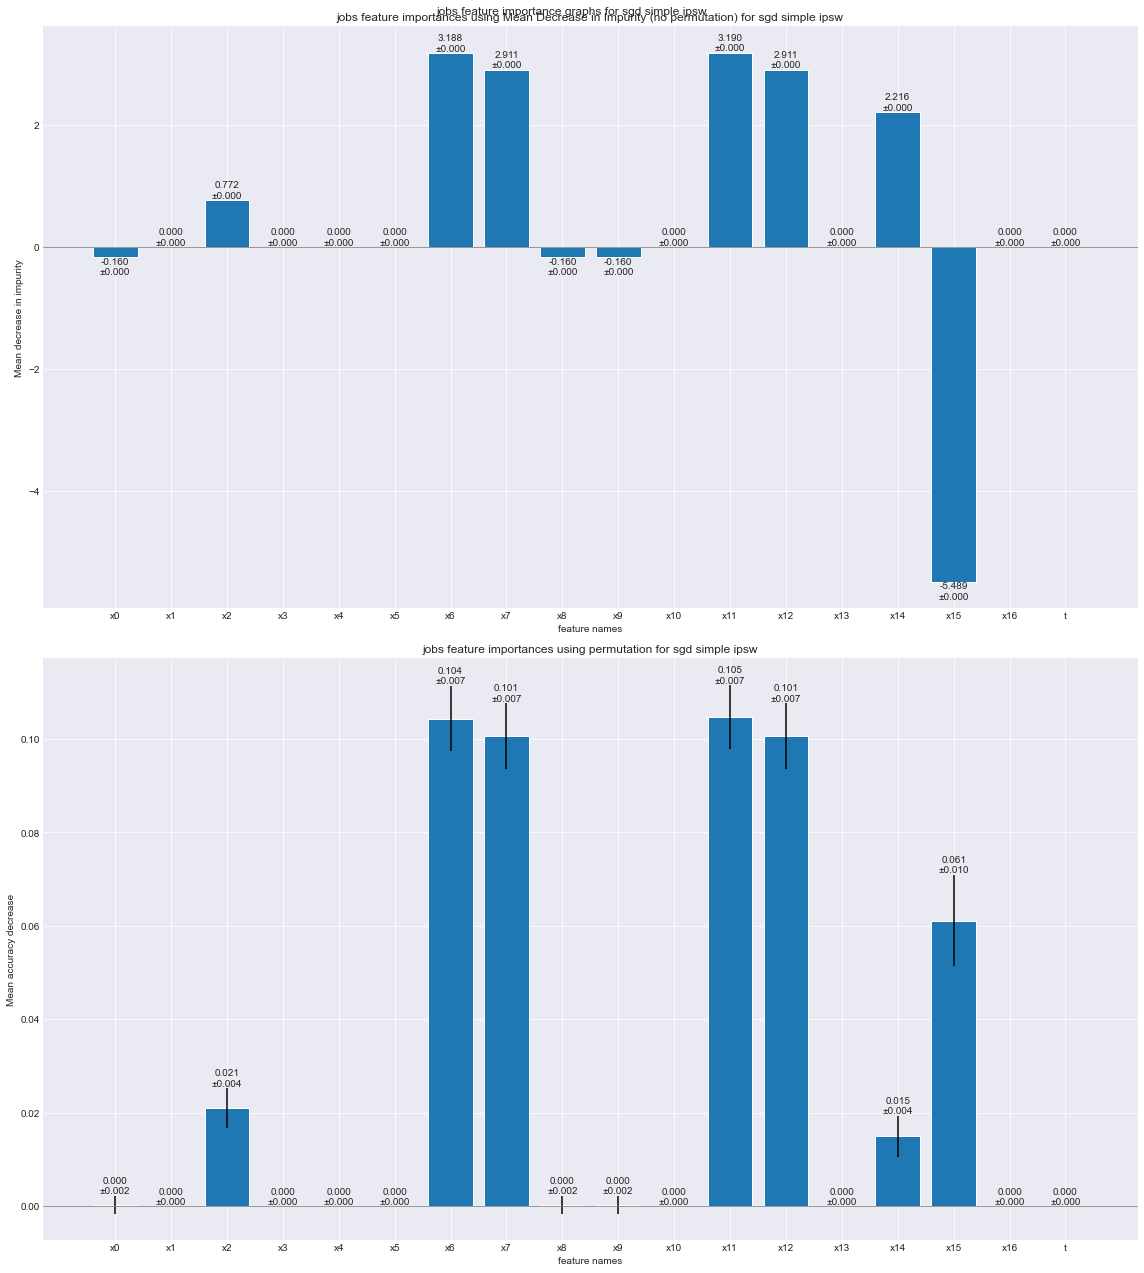

In [135]:
sgd_simple_ipsw_best.importance_plotter().show()

Permutation explainer: 644it [19:33,  1.84s/it]                         


Saving SHAP figure to jobs\jobs SHAP values for sgd simple ipsw.pdf...


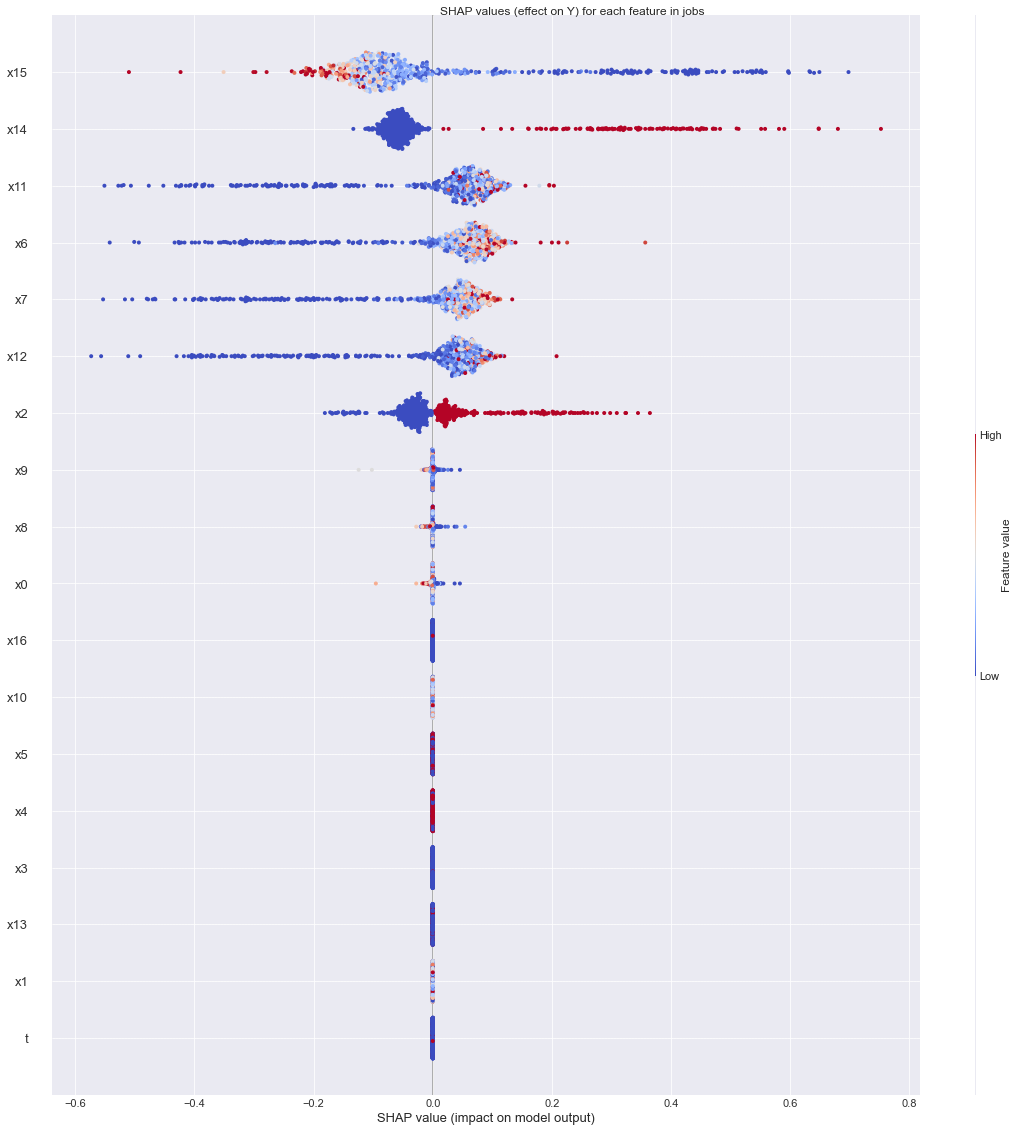

In [136]:
sgd_simple_ipsw_best.shap_importance_plotter().show()

In [ ]:
%%time


ada_rf_simple_ipsw_searched: List[
    slearner.SimpleHalvingGridSearchResults
] = slearner.simple_halving_grid_searcher(
    AdaBoostClassifier(
        random_state=seed()
    ),
    {
        #"Classifier__base_estimator": [
        #    Pipeline(
        #        steps = [i for i in rf.best_estimator_.named_steps.items()]
        #    ) for rf in random_forest_searched_dict.keys()
        #],
        #"Classifier__n_estimators": adaboost_estimators,
        "estimator__learning_rate": adaboost_learn_rate,
        "estimator__base_estimator": [
            *[pl.clone_best_final_estimator for pl in rf_simple_ipsw_searched],
            RandomForestClassifier(random_state=seed()),
            RandomForestClassifier(random_state=seed(), max_depth=10),
            DecisionTreeClassifier(random_state=seed()),
            DecisionTreeClassifier(random_state=seed(), max_depth=10)
        ]
    },
    df_m=dfm,
    df_selection=df_utils.DatasetEnum.FACTUAL,
    learner_name="Adaboost Random Forest simple with IPSW",
    kfold_splits=10,
    scorer_to_use=slearner.roc_auc_id(),
    stratify_on=["t","y"],
    sample_weights=ipsw_calc,
    resource="estimator__n_estimators",
    resource_param_values=adaboost_estimators,
)

In [ ]:

ada_rf_simple_ipsw_best: slearner.SimpleHalvingGridSearchResults = max(
    ada_rf_simple_ipsw_searched
)

In [ ]:

print(ada_rf_simple_ipsw_best.info)

ada_rf_simple_ipsw_best.best_estimator_


In [ ]:
ada_rf_simple_ipsw_best.save_me()

In [ ]:
ada_rf_simple_ipsw_best.importance_plotter().show()

In [ ]:
ada_rf_simple_ipsw_best.shap_importance_plotter().show()

In [ ]:
del rf_simple_ipsw_searched
del ard_simple_ipsw_searched
del sgd_simple_ipsw_searched
del ada_rf_simple_ipsw_searched

In [ ]:
all_simple_ipsw_best: List[slearner.SimpleHalvingGridSearchResults] = [
    rf_simple_ipsw_best,
    ard_simple_ipsw_best,
    sgd_simple_ipsw_best,
    ada_rf_simple_ipsw_best
]

all_simple_ipsw_best.sort(reverse=True)

In [ ]:

for bc in all_simple_ipsw_best:
    print(bc.summary_info)

print("")



In [ ]:
print(max(all_simple_ipsw_best).info)

best_simple_ipsw_predictor: slearner.PPipeline = max(all_simple_ipsw_best).best_estimator_

In [ ]:
best_simple_ipsw_predictor

In [89]:
import dill
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")

ValueError: ctypes objects containing pointers cannot be pickled

# 5: The CATE stuff

In [90]:
import dill
import os
dataset = "jobs"

from sklearn import get_config

dill.load_session(f"{os.getcwd()}\\{dataset}_env.pickle")




import matplotlib.style
if "seaborn-darkgrid" in matplotlib.style.available:
    matplotlib.style.use("seaborn-darkgrid")

%matplotlib inline

set_config(display="diagram")



EOFError: Ran out of input

In [91]:
from assignment2.a2_utils import econml_utils as ecutils



In [ ]:
edfm: ecutils.EconDFM = ecutils.EconDFM.make(
    dfm=dfm,
    ipsw=ipsw_calc
)

In [ ]:
%%time
causalForest_outputs: ecutils.EconMLOutputs = ecutils.EconMLOutputs.make_causal_forest(
    edfm=edfm,
    model_y=sklearn.base.clone(best_simple_est),
    model_t=sklearn.base.clone(best_ipsw_predictor)
)

print(causalForest_outputs.info)

In [ ]:
%%time
print("SHAP feature importances for the causal forest DML")
causalForest_outputs.shap_plot().show()

In [ ]:
%%time
print("Tree-based visualization of the causal forest DML CATE")
causalForest_outputs.plot_tree(
    causalForest_outputs.cate_tree(),
    True
).show()

In [ ]:
%%time
print("Tree-based visualization of the causal forest DML treatment policy")
causalForest_outputs.plot_tree(
    causalForest_outputs.policy_tree(),
    False
).show()

In [ ]:
causalForest_outputs.save_me()

In [ ]:
%%time
forestDR_outputs: ecutils.EconMLOutputs = ecutils.EconMLOutputs.make_ForestDR(
    edfm=edfm,
    model_regression=sklearn.base.clone(best_simple_est),
    model_propensity=sklearn.base.clone(best_ipsw_predictor)
)

print(forestDR_outputs.info)

In [ ]:
%%time
print("SHAP feature importances for the double-robust forest")
forestDR_outputs.shap_plot().show()

In [ ]:
%%time
print("Tree-based visualization of the double-robust forest CATE")
forestDR_outputs.plot_tree(
    forestDR_outputs.cate_tree(),
    True
).show()

In [ ]:
%%time
print("Tree-based visualization of the double-robust forest treatment policy")
forestDR_outputs.plot_tree(
    forestDR_outputs.policy_tree(),
    False
).show()

In [ ]:
forestDR_outputs.save_me()

In [ ]:
best_simple_cate_output: ecutils.EconMLOutputs = max([causalForest_outputs, forestDR_outputs])

print(f"The best CATE estimator out of the CausalForestDML and ForestDR estimators is {best_simple_cate_output.learner_name}")

In [ ]:
%%time
DMLIV_outputs: ecutils.EconMLOutputs = ecutils.EconMLOutputs.make_DMLIV(
    edfm=edfm,
    model_y_xw=sklearn.base.clone(best_simple_ipsw_predictor)
)

print(DMLIV_outputs.info)

In [ ]:
%%time
print("SHAP feature importances for the DMLIV")
DMLIV_outputs.shap_plot().show()

In [ ]:
%%time
print("Tree-based visualization of the DMLIV CATE")
DMLIV_outputs.plot_tree(
    DMLIV_outputs.cate_tree(),
    True
).show()

In [ ]:
%%time
print("Tree-based visualization of the DMLIV treatment policy")
DMLIV_outputs.plot_tree(
    DMLIV_outputs.policy_tree(),
    False
).show()

In [ ]:
DMLIV_outputs.save_me()

%%time

ForestDRIV_outputs: ecutils.EconMLOutputs = ecutils.EconMLOutputs.make_ForestDRIV(
    edfm=edfm,
    model_y_xw=sklearn.base.clone(best_simple_ipsw_predictor)
)
print(ForestDRIV_outputs.info)

print("SHAP feature importances for the ForestDRIV")
ForestDRIV_outputs.shap_plot().show()

print("Tree-based visualization of the ForestDRIV CATE")
ForestDRIV_outputs.plot_tree(
    ForestDRIV_outputs.cate_tree(),
    True
).show()

print("Tree-based visualization of the ForestDRIV treatment policy")
ForestDRIV_outputs.plot_tree(
    ForestDRIV_outputs.policy_tree(),
    False
).show()

In [ ]:
all_cate: List[ecutils.EconMLOutputs] = [
    causalForest_outputs,
    forestDR_outputs,
    DMLIV_outputs,
    #ForestDRIV_outputs
]

all_cate.sort(reverse=True)

for eco in all_cate:
    print(eco.info)
    print("")


In [ ]:
best_cate: ecutils.EconMLOutputs = max(all_cate)

print(f"The best CATE estimator is {best_cate.learner_name}")

In [ ]:
dill.dump_session(f"{os.getcwd()}\\{dataset}_env.pickle")